In [2]:
# ==============================================================================
# --- Tahap 1: Inisialisasi dan Pemuatan Hasil Prediksi ---
# ==============================================================================

import pandas as pd
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# PENTING: Tentukan path ke folder 'predictions' Anda secara manual.
# Sesuaikan path ini jika folder proyek Anda berada di lokasi yang berbeda.
path_prediksi = r'C:\MyFolder\Git\TA_SpatioTemporal\Data\predictions'

# Muat hasil prediksi dari kedua model
try:
    df_lgbm = pd.read_parquet(os.path.join(path_prediksi, 'lgbm_results.parquet'))
    # PENTING: Pastikan Anda memuat file hasil revisi yang baru saja kita buat
    df_lstm = pd.read_parquet(os.path.join(path_prediksi, 'lstm_results_revised.parquet'))
    
    # Pastikan kolom timestamp bertipe datetime untuk penggabungan yang akurat
    df_lgbm['timestamp'] = pd.to_datetime(df_lgbm['timestamp'])
    df_lstm['timestamp'] = pd.to_datetime(df_lstm['timestamp'])

except FileNotFoundError as e:
    print(f"[ERROR] File tidak ditemukan: {e.filename}")
    print("Pastikan kedua file hasil prediksi sudah ada di folder 'predictions'.")


In [3]:
# ==============================================================================
# --- Tahap 2: Penggabungan Cerdas dan Pembersihan ---
# ==============================================================================

# KUNCI UTAMA: Lakukan 'left merge'.
# Ini akan menjaga semua baris dari df_lgbm, dan mencocokkan prediksi dari df_lstm.
# Baris yang tidak cocok (karena periode pemanasan LSTM) akan secara otomatis menjadi NaN.
df_compare = pd.merge(
    df_lgbm,
    df_lstm[['timestamp', 'meter_id', 'prediksi_lstm']],
    on=['timestamp', 'meter_id'],
    how='left'  # <-- Ini adalah perubahan kuncinya!
)

print("DataFrame perbandingan berhasil dibuat.")
display(df_compare.head())

# Sekarang, kita bersihkan baris NaN. Ini akan membuat kedua set prediksi memiliki
# panjang yang sama dan bisa dibandingkan secara adil.
df_compare_cleaned = df_compare.dropna().copy()

print(f"\nTotal baris data uji awal: {len(df_lgbm)}")
print(f"Jumlah baris dengan prediksi LSTM (setelah periode 'pemanasan'): {len(df_lstm)}")
print(f"Jumlah baris yang akan dibandingkan (setelah dibersihkan): {len(df_compare_cleaned)}")

DataFrame perbandingan berhasil dibuat.


,meter_id,is_kelas,is_kantor,is_penelitian,avg_temp_previous_hour,jam,hari_minggu,hari_bulan,minggu_tahun,bulan,tahun,apakah_akhir_pekan,apakah_jam_kerja,konsumsi_lag_1_jam,konsumsi_lag_24_jam,target_aktual,prediksi_lgbm,timestamp,prediksi_lstm
0,BSC A,1,0,1,21.243333,0,1,1,14,4,2025,0,0,17.7875,17.9744,17.8179,17.634205,2025-04-01 00:00:00,NaN
1,BSC A,1,0,1,20.346000,1,1,1,14,4,2025,0,0,17.8179,17.3510,17.5589,17.277740,2025-04-01 01:00:00,NaN
2,BSC A,1,0,1,19.755000,2,1,1,14,4,2025,0,0,17.5589,17.8976,17.3786,17.675691,2025-04-01 02:00:00,NaN
3,BSC A,1,0,1,19.195000,3,1,1,14,4,2025,0,0,17.3786,17.8831,17.4254,17.673428,2025-04-01 03:00:00,NaN
4,BSC A,1,0,1,18.856667,4,1,1,14,4,2025,0,0,17.4254,17.8721,17.1083,17.669811,2025-04-01 04:00:00,NaN



Total baris data uji awal: 48477
Jumlah baris dengan prediksi LSTM (setelah periode 'pemanasan'): 47541
Jumlah baris yang akan dibandingkan (setelah dibersihkan): 47541


In [6]:
# ==============================================================================
# --- Tahap 3: Perbandingan Metrik Agregat (DIPERBAIKI) ---
# ==============================================================================

# Hitung metrik hanya pada data yang bersih
# Menggunakan 'target_aktual' sebagai nama kolom nilai sebenarnya yang konsisten
y_true = df_compare_cleaned['target_aktual'] # <-- DIUBAH
y_pred_lgbm = df_compare_cleaned['prediksi_lgbm']
y_pred_lstm = df_compare_cleaned['prediksi_lstm']

metrics = {
    'LightGBM': {
        'MAE': mean_absolute_error(y_true, y_pred_lgbm),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred_lgbm)),
        'R²': r2_score(y_true, y_pred_lgbm),
        'sMAPE (%)': np.mean(2 * np.abs(y_pred_lgbm - y_true) / (np.abs(y_true) + np.abs(y_pred_lgbm))) * 100
    },
    'LSTM': {
        'MAE': mean_absolute_error(y_true, y_pred_lstm),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred_lstm)),
        'R²': r2_score(y_true, y_pred_lstm),
        'sMAPE (%)': np.mean(2 * np.abs(y_pred_lstm - y_true) / (np.abs(y_true) + np.abs(y_pred_lstm))) * 100
    }
}

df_metrics = pd.DataFrame(metrics).round(2)

print("\n\n--- Tabel Perbandingan Metrik Kinerja Model ---")
print(df_metrics)



--- Tabel Perbandingan Metrik Kinerja Model ---
           LightGBM   LSTM
MAE            1.62   2.48
RMSE           4.28   5.56
R²             0.98   0.96
sMAPE (%)     14.57  22.45


In [7]:
# ==============================================================================
# --- Tahap 4: Perbandingan Kinerja per Gedung (DIPERBAIKI) ---
# ==============================================================================

# Hitung MAE per gedung menggunakan 'target_aktual'
mae_lgbm_per_gedung = df_compare_cleaned.groupby('meter_id').apply(lambda x: mean_absolute_error(x['target_aktual'], x['prediksi_lgbm'])) # <-- DIUBAH
mae_lstm_per_gedung = df_compare_cleaned.groupby('meter_id').apply(lambda x: mean_absolute_error(x['target_aktual'], x['prediksi_lstm'])) # <-- DIUBAH

# Gabungkan menjadi satu DataFrame
df_error_gedung = pd.DataFrame({
    'MAE_LightGBM': mae_lgbm_per_gedung,
    'MAE_LSTM': mae_lstm_per_gedung
})

# Tambahkan kolom pemenang
df_error_gedung['Pemenang'] = np.where(df_error_gedung['MAE_LightGBM'] < df_error_gedung['MAE_LSTM'], 'LightGBM', 'LSTM')

print("\n\n--- Tabel Perbandingan Error (MAE) per Gedung ---")
print(df_error_gedung.sort_values(by='MAE_LSTM').round(2))




--- Tabel Perbandingan Error (MAE) per Gedung ---
                            MAE_LightGBM  MAE_LSTM  Pemenang
meter_id                                                    
Pompa Air - PAU                     0.03      0.15  LightGBM
Pompa Air - Sabuga                  0.07      0.28  LightGBM
Kantor FSRD                         0.22      0.30  LightGBM
PSDA                                0.21      0.32  LightGBM
LABTEK XI                           0.38      0.44  LightGBM
SBM MBA                             0.33      0.49  LightGBM
LAB. KONVERSI                       0.32      0.50  LightGBM
Gardu Konversi                      0.34      0.50  LightGBM
Kantor FTSL                         0.34      0.57  LightGBM
LABTEK VII                          0.56      0.70  LightGBM
Lab. Mekanika Fluida                0.36      0.75  LightGBM
Lab. PLN-ITB                        0.64      0.97  LightGBM
BSC A                               0.56      1.15  LightGBM
Gedung Teknik Lingkungan         

C:\Users\Danu Hakim\AppData\Local\Temp\ipykernel_27024\3405856227.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_lgbm_per_gedung = df_compare_cleaned.groupby('meter_id').apply(lambda x: mean_absolute_error(x['target_aktual'], x['prediksi_lgbm'])) # <-- DIUBAH
C:\Users\Danu Hakim\AppData\Local\Temp\ipykernel_27024\3405856227.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_lstm_per_gedung = d

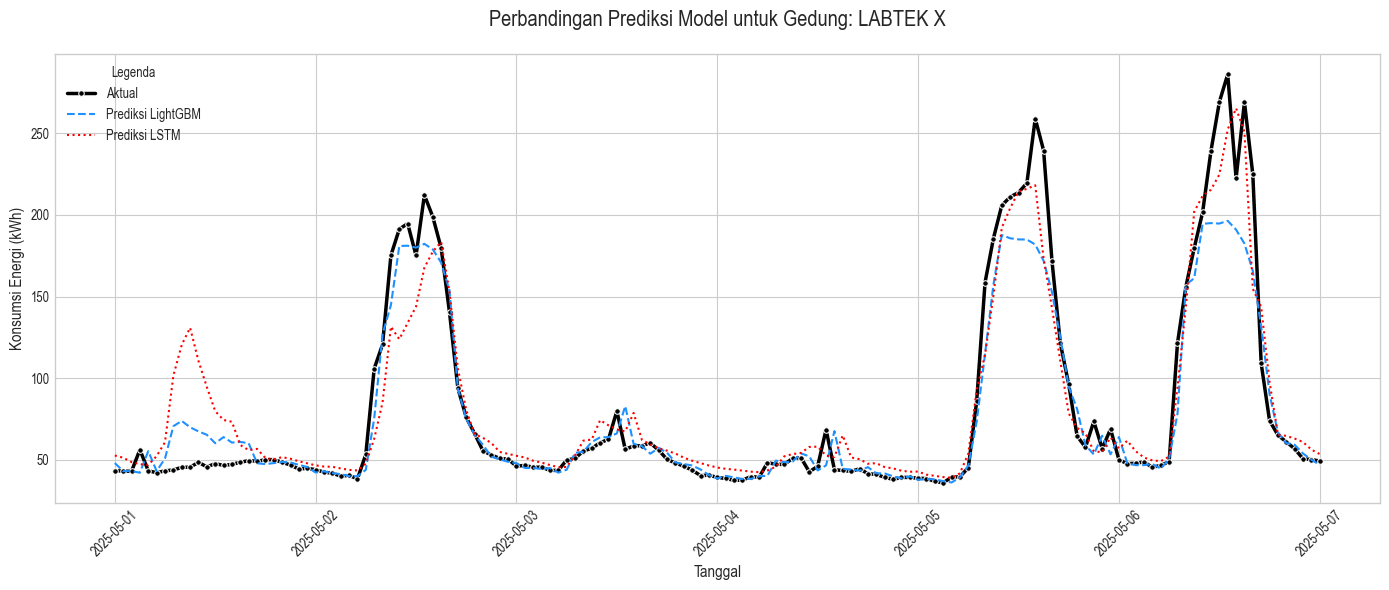

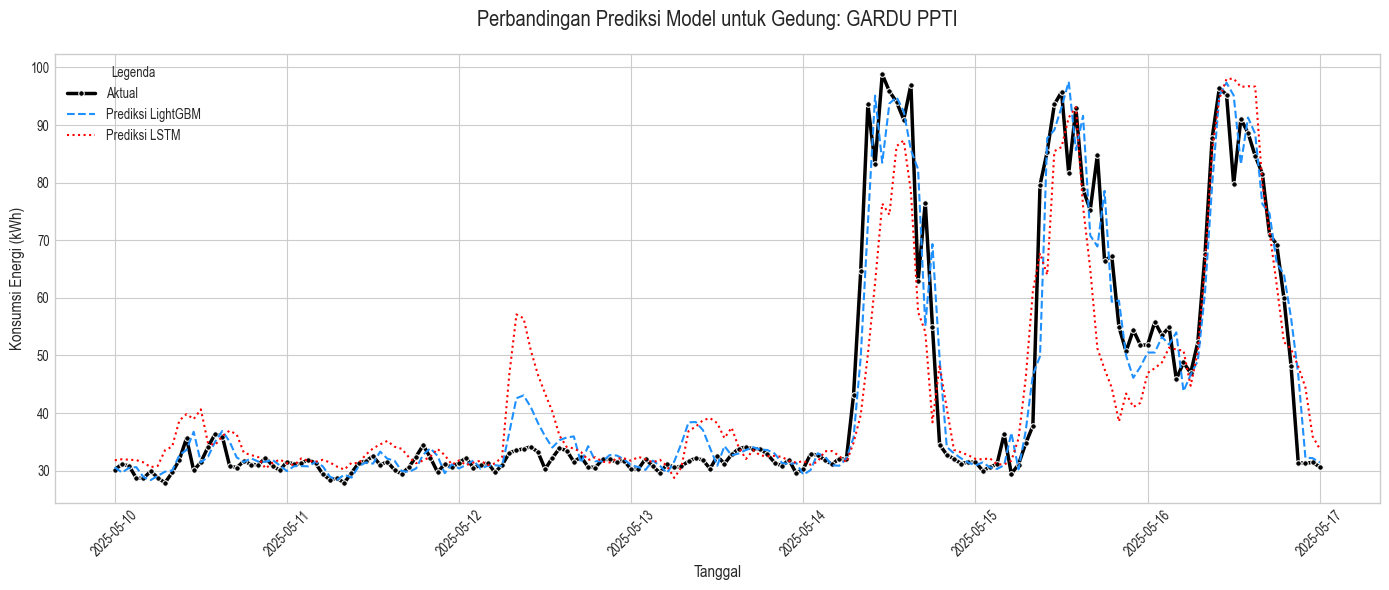

In [21]:
# ==============================================================================
# --- Tahap 5: Visualisasi Perbandingan (DITAMBAHKAN & DIPERBAIKI) ---
# ==============================================================================
from mydef import plot_perbandingan_model
# Panggil fungsi untuk melihat perbandingan.
# Anda bisa mengubah parameter ini untuk melihat gedung atau rentang waktu yang berbeda.
# Fungsi ini dipanggil menggunakan 'df_compare' (sebelum dropna) agar bisa menampilkan 
# periode di mana mungkin hanya ada prediksi LightGBM.
plot_perbandingan_model(
    df=df_compare, 
    meter_id='LABTEK X', 
    start_date='2025-05-01', 
    end_date='2025-05-07' # <-- Diubah menjadi rentang 1 minggu agar lebih jelas
)

plot_perbandingan_model(
    df=df_compare, 
    meter_id='GARDU PPTI', 
    start_date='2025-05-10', 
    end_date='2025-05-17'
)
